In [5]:
!unzip -q trafic_32.zip

In [1]:
%pip install lightning optuna torchmetrics[image] kornia optuna-integration torch-fidelity tensorboard matplotlib
%load_ext tensorboard

  Using cached lightning-2.2.4-py3-none-any.whl.metadata (53 kB)
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
  Using cached kornia-0.7.2-py2.py3-none-any.whl.metadata (12 kB)
  Using cached optuna_integration-3.6.0-py3-none-any.whl.metadata (10 kB)
  Using cached torch_fidelity-0.3.0-py3-none-any.whl.metadata (2.0 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached matplotlib-3.8.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached torchmetrics-1.4.0-py3-none-any.whl.metadata (19 kB)
  Using cached lightning_utilities-0.11.2-py3-none-any.whl.metadata (4.7 kB)
  Using cached pytorch_lightning-2.2.4-py3-none-any.whl.metadata (21 kB)
  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached SQLAlchemy-2.0.30-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached pretty_error

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as FV
import torch.optim
from torch.utils.data import DataLoader, TensorDataset, random_split

from tqdm import tqdm
import os

import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import lightning as L
from torchmetrics import Accuracy
from lightning.pytorch.loggers import TensorBoardLogger
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import kornia.augmentation as Kaug
import kornia as K
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image
import os
from torchmetrics.image.fid import FrechetInceptionDistance
import optuna

from utils import show
from data import get_sanity_dataset, ClassSampler, DiffiusionDataModule, PreProcess
from blocks import UNet, UpBlock, DownBlock, ResidualBlock
from noise import sinusoidal_embedding, cosine_diffusion_schedule, LinearNoiseScheduler

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
NUM_WORKERS = int(os.cpu_count() / 2)
CLASSES_NO = 43
NUM_STEPS = 1000
plt.rcParams["savefig.bbox"] = 'tight'

In [3]:
def normalize(tensor):
        min_val = tensor.view(tensor.size(0), -1).min(dim=1, keepdim=True)[0]
        max_val = tensor.view(tensor.size(0), -1).max(dim=1, keepdim=True)[0]
        return (tensor - min_val[:, :, None, None]) / (max_val[:, :, None, None] - min_val[:, :, None, None] + 1e-8)
def validate_linear_scheduler():
    dt, kr = get_sanity_dataset()
    x, y = next(iter(dt))
    x, y = x.to(DEVICE), y.to(DEVICE)
    # show(x.cpu(), False)
    x = kr(x)
    num_steps = 1000
    scheduler = LinearNoiseScheduler(num_steps, DEVICE, 1e-4, 5e-3)
    t = torch.linspace(0, num_steps-1, x.shape[0], dtype=torch.int32)
    noise = torch.randn_like(x)
    x_noisy, sr, nr = scheduler.add_noise(x, noise, t)
    
    mean = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)
    std = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)
    show(torch.cat([normalize(x_noisy), normalize(nr*noise)], dim=0).cpu(), False)




### Noise schedule validate

torch.Size([16, 1, 1, 1]) torch.Size([16, 1, 1, 1]) torch.Size([16])


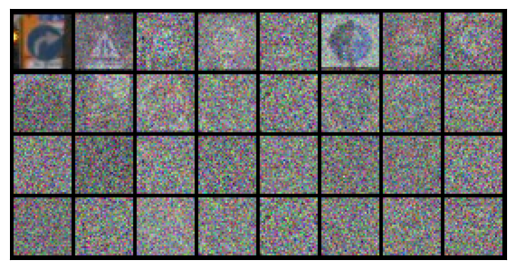

In [6]:
validate_linear_scheduler()

In [13]:
t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
scheduler = LinearNoiseScheduler(NUM_STEPS, DEVICE)
sinusoidal_embedding(scheduler.get_variance(t)).expand(-1, -1, 32, 32).shape

torch.Size([16, 32, 32, 32])

100%|██████████| 16/16 [00:01<00:00, 11.82it/s]


Validation Loss after epoch 1: 0.1285800407640636


100%|██████████| 16/16 [00:01<00:00, 11.55it/s]


Validation Loss after epoch 2: 0.09595251874998212


100%|██████████| 16/16 [00:01<00:00, 11.50it/s]


Validation Loss after epoch 3: 0.08094818470999599


100%|██████████| 16/16 [00:01<00:00, 11.26it/s]


Validation Loss after epoch 4: 0.07125976448878646


100%|██████████| 16/16 [00:01<00:00, 11.64it/s]


Validation Loss after epoch 5: 0.06784360855817795


100%|██████████| 16/16 [00:01<00:00, 11.11it/s]


Validation Loss after epoch 6: 0.05982535961084068


100%|██████████| 16/16 [00:01<00:00, 11.44it/s]


Validation Loss after epoch 7: 0.0618218386080116


100%|██████████| 16/16 [00:01<00:00, 11.23it/s]


Validation Loss after epoch 8: 0.057908874936401844


100%|██████████| 16/16 [00:01<00:00, 11.47it/s]


Validation Loss after epoch 9: 0.0538715950679034


100%|██████████| 16/16 [00:01<00:00, 10.96it/s]


Validation Loss after epoch 10: 0.05518491403199732


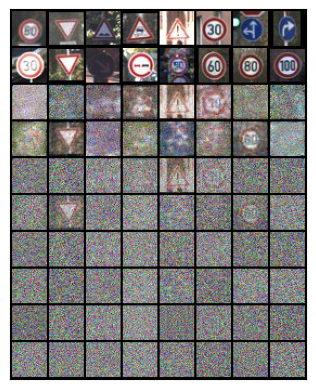

In [4]:
from blocks import UNet, UpBlock, DownBlock, ResidualBlock
def validate_unet():
    dt, kr = get_sanity_dataset(256)
    dv, kr = get_sanity_dataset(256, 'val')
    model = UNet(CLASSES_NO, DEVICE, sinusoidal_embedding).to(DEVICE)
    scheduler = LinearNoiseScheduler(NUM_STEPS, DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for ep in range(10):
        i = 0
        for x, y in tqdm(dt):
            if i > 10:
                break
            x, y = x.to(DEVICE), y.to(DEVICE)
            x = kr(x)
            optimizer.zero_grad()
            t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
            noise = torch.randn_like(x, device=DEVICE)
            noised = scheduler.add_noise(x, noise, t)[0]
            # noised = torch.clamp(noised, -1, 1)
            logits = model(noised, scheduler.get_variance(t), y)
            loss = criterion(noise, logits)
            loss.backward()
            optimizer.step()
            i+=1
        model.eval()
        val_losses = []
        with torch.no_grad():
            for x, y in tqdm(dv):
                x, y = x.to(DEVICE), y.to(DEVICE)
                x = kr(x)
                
                t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
                noise = torch.randn_like(x, device=DEVICE)
                noised = scheduler.add_noise(x, noise, t)[0]
                # noised = torch.clamp(noised, -1, 1)
                logits = model(noised, scheduler.get_variance(t), y)
                loss = criterion(noise, logits)
                val_losses.append(loss.item())
            avg_val_loss = sum(val_losses) / len(val_losses)
            print(f"Validation Loss after epoch {ep+1}: {avg_val_loss}")
    model.eval()
    with torch.no_grad():
        x, y = next(iter(dt))
        x, y = x.to(DEVICE), y.to(DEVICE)
        x = kr(x)
        
        t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
        noise = torch.randn_like(x, device=DEVICE)
        noised, signal_rates, noise_rates = scheduler.add_noise(x, noise, t)
        # noised = torch.clamp(noised, -1, 1)
        logits = model(noised, scheduler.get_variance(t), y)
        loss = criterion(noise, logits)
        pred_images = (noised - (noise_rates) * logits) / signal_rates
        show(torch.cat([
            normalize(x.cpu())[:16],
            normalize(pred_images.cpu())[:16],
            normalize(noised.cpu())[:16],
            normalize(noise.cpu())[:16],
            normalize(logits.cpu())[:16]
        ], dim=0), False)
    return model
unet_model = validate_unet()

### UNet validate

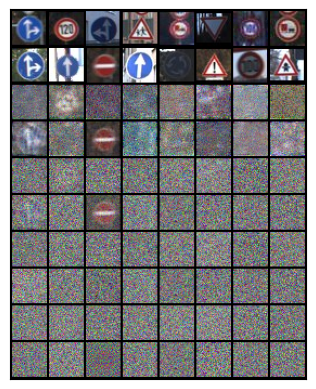

In [13]:
scheduler = LinearNoiseScheduler(NUM_STEPS, DEVICE)
dt, kr = get_sanity_dataset(256)

unet_model.eval()
with torch.no_grad():
    x, y = next(iter(dt))
    x, y = x.to(DEVICE), y.to(DEVICE)
    x = kr(x)
    
    t = torch.randint(0, NUM_STEPS-1, (x.shape[0],), device=DEVICE)
    noise = torch.randn_like(x, device=DEVICE)
    noised, signal_rates, noise_rates = scheduler.add_noise(x, noise, t)
    # noised = torch.clamp(noised, -1, 1)
    logits = unet_model(noised, scheduler.get_variance(t), y)
    pred_images = (noised - noise_rates * logits) / signal_rates
    show(torch.cat([
            normalize(x.cpu())[:16],
            normalize(pred_images.cpu())[:16],
            normalize(noised.cpu())[:16],
            normalize(noise.cpu())[:16],
            normalize(logits.cpu())[:16]
        ], dim=0), False)

In [3]:
from blocks import UNet

class DiffusionModel(L.LightningModule):
    def __init__(self, sampler, model=None, transform=None, trial=None, diff_scheduler=cosine_diffusion_schedule,learning_rate=1e-3, class_emb_size=8, transformed_class_emb=32):
        super(DiffusionModel, self).__init__()
        self.save_hyperparameters()
        
        self.network: UNet = UNet(CLASSES_NO, DEVICE, sinusoidal_embedding,class_emb_size=self.hparams.class_emb_size, latent_class_emb_size=self.hparams.transformed_class_emb).to(DEVICE) if model is None else model
        self.sampler = sampler
        self.transform = transform if transform is not None else transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        self.cosine_diffusion_schedule = diff_scheduler
        self.trial = trial
        self.scheduler = LinearNoiseScheduler(NUM_STEPS, DEVICE)

    def forward(self, noisy_images, noise_rates, class_labels):
        return self.network(noisy_images, noise_rates, class_labels)

    @torch.no_grad()
    def denoise(self, noisy_images, noise_rates, signal_rates, class_labels):
        pred_noises = self(noisy_images, noise_rates, class_labels)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        return pred_noises, pred_images

    @torch.no_grad()
    def reverse_diffusion(self, initial_noise, diffusion_steps, class_labels):
        num_images = initial_noise.size(0)
        def normalize(tensor):
            min_val = tensor.view(tensor.size(0), -1).min(dim=1, keepdim=True)[0]
            max_val = tensor.view(tensor.size(0), -1).max(dim=1, keepdim=True)[0]
            return (tensor - min_val[:, :, None, None]) / (max_val[:, :, None, None] - min_val[:, :, None, None] + 1e-8)
        t = NUM_STEPS- torch.ones((num_images,), device=initial_noise.device, dtype=torch.int32) * 0-1
        signal_rates, noise_rates = self.scheduler.get_rates(t)
        current_images = initial_noise
        for step in range(diffusion_steps):
            with torch.no_grad():
                t-=1
                pred_noises, pred_images = self.denoise(current_images, noise_rates, signal_rates, class_labels)
                current_images, signal_rates, noise_rates = self.scheduler.add_noise(pred_images, pred_noises, t)
                # current_images = normalize(current_images)
        return normalize(current_images)

    def denormalize(self, images):
        mean = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)
        var = torch.tensor((0.5, 0.5, 0.5), device=DEVICE).view(1, 3, 1, 1)
        images = mean + images * var
        return images

    @torch.no_grad()
    def generate(self, num_images, diffusion_steps):
        self.network.eval()
        initial_noise = torch.randn(num_images, 3, 32, 32, device=DEVICE)
        class_labels = self.sampler.sample(initial_noise)
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps, class_labels)
        # generated_images = self.denormalize(generated_images)
        return generated_images
    
    def corrupt(self, images):
        noise = torch.randn_like(images)
        t = torch.randint(0, NUM_STEPS-1, (images.shape[0],), device=DEVICE)
        noised, signal_rates, noise_rates = self.scheduler.add_noise(images, noise, t)
        return noise, noised, noise_rates, signal_rates

    def training_step(self, batch, batch_idx):
        images, class_labels = batch
        images, class_labels = images.to(DEVICE), class_labels.to(DEVICE)
        
        if self.transform is not None:
            images = self.transform(images.to(DEVICE))
        noises, noised_imgs, noise_rate, signal_rate = self.corrupt(images)

        pred_noises = self.network(noised_imgs, noise_rate, class_labels)
        loss = F.mse_loss(noises, pred_noises)
        self.log('train_loss', loss)
        return loss
    def normalize(self, tensor):
            tensor = self.denormalize(tensor)
            min_val = tensor.view(tensor.size(0), -1).min(dim=1, keepdim=True)[0]
            max_val = tensor.view(tensor.size(0), -1).max(dim=1, keepdim=True)[0]
            return (tensor - min_val[:, :, None, None]) / (max_val[:, :, None, None] - min_val[:, :, None, None] + 1e-8)

    def validation_step(self, batch, batch_idx):
        images, class_labels = batch
        if self.transform is not None:
            images = self.transform(images.to(DEVICE))

        noise = torch.randn_like(images)
        t = torch.randint(0, NUM_STEPS-1, (images.shape[0],), device=DEVICE)
        noised, signal_rates, noise_rates = self.scheduler.add_noise(images, noise, t)

        pred_noises, pred_images = self.denoise(noised, noise_rates, signal_rates, class_labels)
        loss = F.mse_loss(noise, pred_noises)
        
        self.log('val_loss', loss)
        
        self.logger.experiment.add_image("rectonstructed_images", make_grid(self.normalize(pred_images[:64])), self.current_epoch)    
        if self.trial is not None:
            self.trial.report(loss, self.current_epoch)
            
    def on_validation_epoch_end(self):
        if self.current_epoch % 10 == 0:
            initial_noise = torch.randn(CLASSES_NO, 3, 32, 32, device=DEVICE)
            class_labels = torch.arange(CLASSES_NO, device=DEVICE)
            generated_images = self.reverse_diffusion(initial_noise, 999, class_labels)
            self.logger.experiment.add_image("generated_images", make_grid(self.normalize(generated_images)), self.current_epoch)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.network.parameters(), lr=self.hparams.learning_rate)
        return optimizer

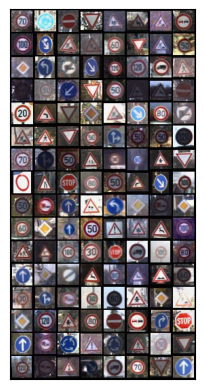

In [8]:
model = DiffusionModel.load_from_checkpoint("/home/Stable-diffusion/logs/dev/dev_19/checkpoints/epoch=199-step=27600.ckpt")
photos = model.generate(128, 999).cpu()
show(photos, False)

In [16]:
import torch
from torchvision.utils import save_image
import os

num_images = 128

save_dir = 'generated_images'
os.makedirs(save_dir, exist_ok=True)

# Save each image in the batch
for i in range(num_images):
    image = photos[i]  # Select the i-th image
    save_path = os.path.join(save_dir, f'image_{i}.png')
    save_image(image, save_path)
save_image(make_grid(photos, nrow=8), 'grid.png')
print(f'Saved {num_images} images to {save_dir}')

Saved 128 images to generated_images


In [4]:
logger = TensorBoardLogger("logs", name="dev", version="dev_19")
sampler = ClassSampler(ImageFolder('trafic_32'), DEVICE)
model = DiffusionModel(sampler).to(DEVICE)
trainer = L.Trainer(max_epochs=200, 
                        accelerator="gpu", 
                        # callbacks=[L.pytorch.callbacks.EarlyStopping(monitor='val_loss', patience=7, strict=False, verbose=False, mode='min')],
                        logger=logger
                        )
trainer.fit(model, DiffiusionDataModule(), ckpt_path="/home/Stable-diffusion/logs/dev/dev_19/checkpoints/epoch=10-step=1518.ckpt")
# trainer.fit(model, DiffiusionDataModule())


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 6000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory logs/dev/dev_19/checkpoints exists and is not empty.
Restoring states from the checkpoint path at /home/Stable-diffusion/logs/dev/dev_19/checkpoints/epoch=10-step=1518.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params
----------------------------------------
0 | network   | UNet      | 139 M 
1 | transform | No

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


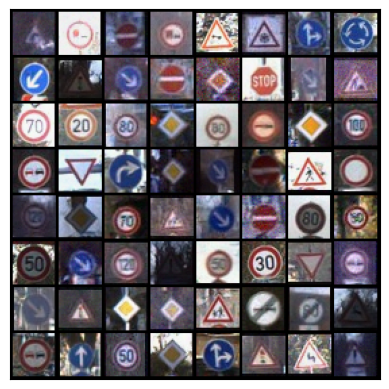

In [17]:
photos = model.generate(1000, 999).cpu()
torch.save(photos.detach(), "piatek_szawerda_jarczewski.pt")
show(photos[:64], False)

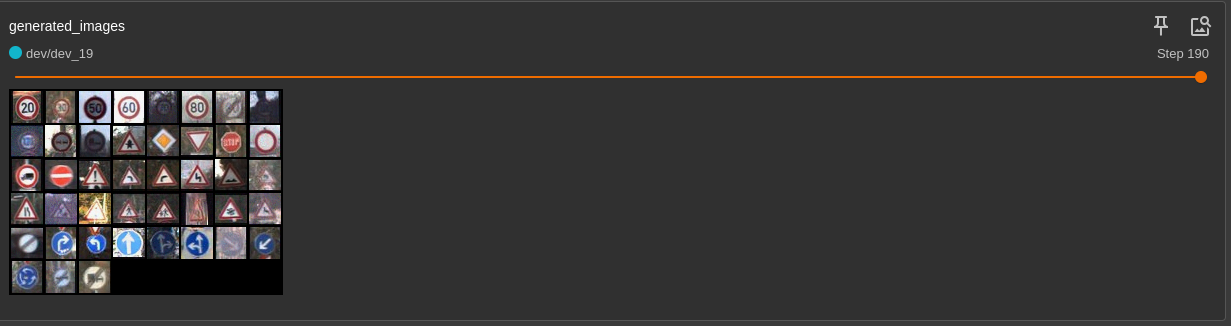
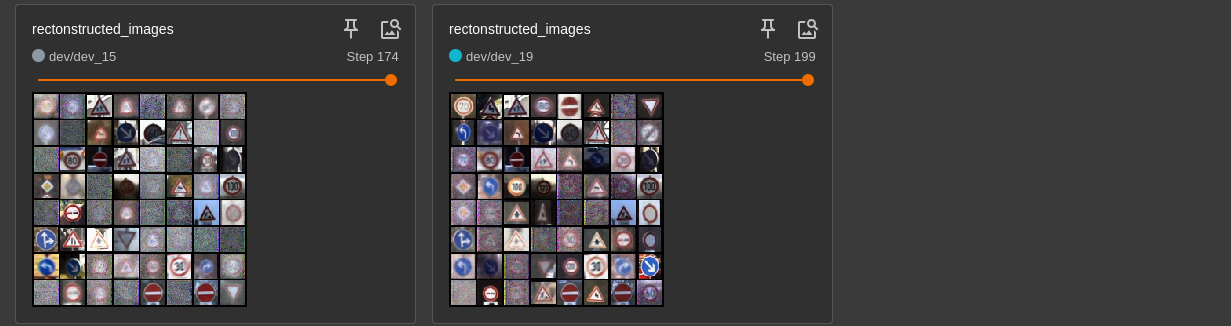
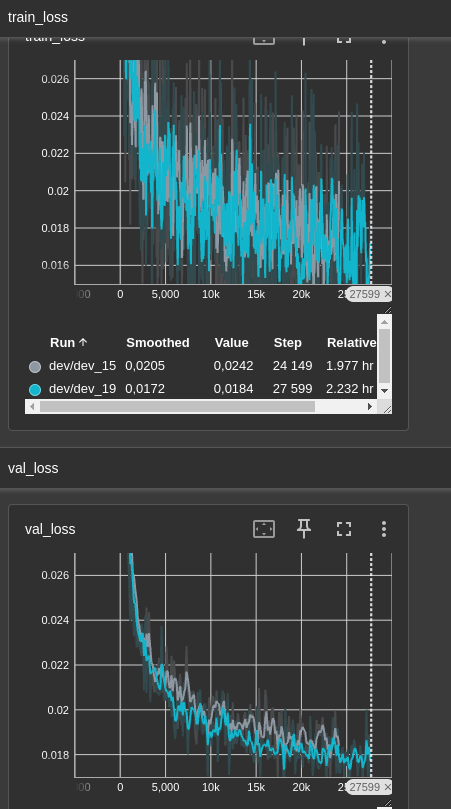
